<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install tf-nightly-2.0-preview

    100% |████████████████████████████████| 86.8MB 295kB/s 
    100% |████████████████████████████████| 61kB 21.9MB/s 
    100% |████████████████████████████████| 3.1MB 11.3MB/s 
    100% |████████████████████████████████| 430kB 20.3MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
import tensorflow as tf 
from tensorflow import keras

In [267]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190421


In [0]:
nx = 10
ny = 10

dx = 1. / nx
dy = 1. / ny

x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)

In [0]:
def f(x):
    return 0.

def A(x):
    return x[1] * np.sin(np.pi * x[0])


def psy_trial(x, net_out):
    return A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

In [0]:
model = Sequential()
model.add(Dense(10, input_shape=(1,2),activation='relu'))
model.add(Dense(10))
model.add(Dense(1, activation='tanh'))
optimizer = tf.keras.optimizers.Adam()

In [303]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 1, 10)             30        
_________________________________________________________________
dense_33 (Dense)             (None, 1, 10)             110       
_________________________________________________________________
dense_34 (Dense)             (None, 1, 1)              11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_space = np.linspace(0, 2, nx).astype('float32').reshape(10,1)
y_space = np.linspace(0, 2, ny).astype('float32').reshape(10,1)
xv, yv = np.meshgrid(x_space, y_space)

In [0]:
x = np.stack((xv.reshape(100), yv.reshape(100)), axis=-1).reshape(100, 1, 2)
x = tf.constant(x)

In [314]:
model(x[0])

<tf.Tensor: id=9032555, shape=(1, 1), dtype=float32, numpy=array([[0.00392235]], dtype=float32)>

In [315]:
net_out = model(x[0])
psy_trial(x[0][0], net_out[0][0])

<tf.Tensor: id=9032628, shape=(), dtype=float32, numpy=0.0>

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [207]:
loss_function([0], [0])

<tf.Tensor: id=6392327, shape=(), dtype=int32, numpy=0>

In [0]:
# @tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(x)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x[0], net_out[0][0])

            dy_dx = gg.gradient(psy_t, x)
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient

        func = f(x) # right part function
        loss = loss_function([d2y_dx2[0][0] + d2y_dx2[0][1]], [func])
        
    grads = g_total.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

# Test Gradient

In [331]:
x_test = x[28]
print(x_test)
with tf.GradientTape() as gg:
    gg.watch(x_test)
    net_out = model(x_test)
    psy_t = psy_trial(x_test[0], net_out[0][0])
    print(net_out, psy_t)
dy_dx = gg.jacobian(psy_t, x_test)
print(dy_dx)


# with tf.GradientTape() as g:
#     g.watch(x_test)
#     with tf.GradientTape() as gg:
#         gg.watch(x_test)
#         psy_t = psy_trial(x_test[0], net_out[0][0])
#     dy_dx = gg.jacobian(psy_t, x_test)
#     print(dy_dx)
# d2y_dx2 = g.jacobian(dy_dx, x_test)

tf.Tensor([[1.7777778  0.44444445]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.25910726]], shape=(1, 1), dtype=float32) tf.Tensor(-0.19722113, shape=(), dtype=float32)
tf.Tensor([[ 0.23248413 -0.696623  ]], shape=(1, 2), dtype=float32)


In [318]:
train_on_batch(x[10])

<tf.Tensor: id=9033517, shape=(), dtype=float32, numpy=1.5907348e-06>

In [309]:
for i in range(20):
    for xi in x:
        loss = train_on_batch(xi)
    print(loss)

tf.Tensor(0.019801216, shape=(), dtype=float32)
tf.Tensor(28.534529, shape=(), dtype=float32)
tf.Tensor(0.008407898, shape=(), dtype=float32)
tf.Tensor(0.54011023, shape=(), dtype=float32)
tf.Tensor(0.1579932, shape=(), dtype=float32)
tf.Tensor(0.0638818, shape=(), dtype=float32)
tf.Tensor(0.006187341, shape=(), dtype=float32)
tf.Tensor(0.0030072327, shape=(), dtype=float32)
tf.Tensor(0.032493733, shape=(), dtype=float32)
tf.Tensor(0.09007988, shape=(), dtype=float32)
tf.Tensor(0.20493136, shape=(), dtype=float32)
tf.Tensor(0.30786103, shape=(), dtype=float32)
tf.Tensor(0.37930232, shape=(), dtype=float32)
tf.Tensor(0.42226583, shape=(), dtype=float32)
tf.Tensor(0.8440333, shape=(), dtype=float32)
tf.Tensor(0.99586964, shape=(), dtype=float32)
tf.Tensor(0.5497012, shape=(), dtype=float32)
tf.Tensor(0.23745961, shape=(), dtype=float32)
tf.Tensor(0.014694546, shape=(), dtype=float32)
tf.Tensor(0.0005127446, shape=(), dtype=float32)


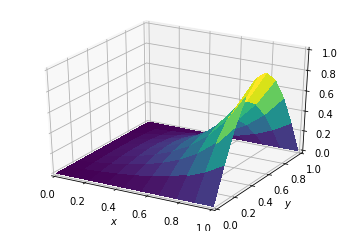

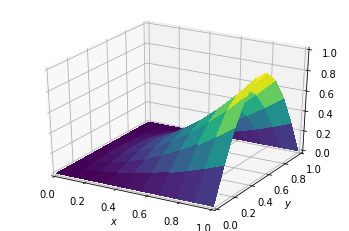

In [280]:
x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def analytic_solution(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
    		np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)


surface1 = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface1[i][j] = psy_trial((x,y), model(np.array([x,y]).reshape(1,2))[0][0].numpy())
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface1, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [310]:
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        print(model(np.array([x,y]).reshape(1,2))[0][0].numpy())

0.0039223465
0.002132914
-0.0005591796
-0.0020788752
-0.002119619
-0.0021604227
-0.0022012165
-0.002241992
-0.0022825773
-0.0023235024
-0.028497154
0.0029646715
0.00027257882
-0.0013597829
-0.0014005691
-0.0014412929
-0.0014821332
-0.0015229987
-0.0015636288
-0.0016045535
-0.06969417
-0.04218352
0.001104321
-0.0006408017
-0.00068152376
-0.00072230253
-0.00076313264
-0.00080377655
-0.00084466016
-0.00088536495
-0.11065483
-0.090128355
-0.025138006
-0.00017097282
3.749813e-05
-3.1634115e-06
-4.399911e-05
-8.469511e-05
-0.00012549634
-0.00016629479
-0.15124299
-0.13765898
-0.073177256
-0.0073563065
4.347815e-05
0.00071582495
0.0006750227
0.00063422153
0.0005935143
0.00055268616
-0.1913275
-0.18456404
-0.120879315
-0.055576846
-0.0064964877
0.00025786672
0.0013941883
0.0013534131
0.001312623
0.0012718899
-0.23078379
-0.23064311
-0.1680296
-0.10353942
-0.03601464
-0.006282054
0.00047232042
0.0020724495
0.0020316439
0.0019908028
-0.26949546
-0.2757104
-0.2144234
-0.15102538
-0.08410881
-0.01